In [198]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import pandas as pd
import sys
import warnings

import matplotlib.pyplot as plt

folder = os.path.abspath('')
utilspath = os.path.normpath(os.path.join(folder, 'utils'))
sys.path.append(utilspath)

from environment import RandomLatentEnvironment
from environment import YouTubeEnvironment
from experiment_setup_utils import run_reachability_experiment, run_dataset_future_experiment
from experiment_setup_utils import run_dataset_history_experiment, run_dataset_nextk_experiment
from experiment_setup_utils import load_dataset_experiment, make_combined_experiment_df
from helper_utils import entrywise_division
from mask_utils import make_random_mask

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
! pip install --upgrade seaborn

Requirement already up-to-date: seaborn in /Users/mcurmei/anaconda3/lib/python3.7/site-packages (0.11.1)


In [2]:
# Plotting settings
from matplotlib import gridspec, rc
from matplotlib import ticker as mticker
import matplotlib.pyplot as plt
import seaborn as sns

rc('text', usetex = True)
rc('font', family = 'serif')
TITLE_SIZE = 27
LABEL_SIZE = 22
LEGEND_TITLE_SIZE = 25
LEGEND_SIZE = 20
TICK_SIZE = 18
FONT = 'serif'
params = {}
params['legend.title_fontsize'] = LEGEND_TITLE_SIZE
params['axes.labelsize'] = LABEL_SIZE
params['axes.titlesize'] = TITLE_SIZE
params['legend.fontsize'] = LEGEND_SIZE
params["xtick.labelsize"]= TICK_SIZE
params["ytick.labelsize"] = TICK_SIZE
params["font.family"] = "Times New Roman"
context = sns.plotting_context("paper", rc=params)
sns.set_theme(style="white", font=FONT)

# Reachability audit demonstration
Before proceeding with this demo ensure that you have installed the `RecLab` package. To install it and the rest of the dependencies follow the instructions in the `README.md` file.


## Recommendation environments
`environment.py` in the `utils` folder contains several recommendation environments. Typically an environment can be understood as the composition of a historical ratings dataset and a trained recommender. We provide recommendation environments based on syntetic data as well as real data from movie recommendations: `MovieLens`, music recommendations: `LastFM` and news recommendation `MIND`.

### Creating a syntetic recommendation environments

In [3]:
N_USERS = 10
N_ITEMS = 30

# instanciate an empty environment
env = RandomLatentEnvironment(N_USERS, N_ITEMS, latent_dim = 16)

In [4]:
# Initialize the enviroment:
#  - creates underlying ratings
#  - samples observed ratings
#  - trains a preference model on the observed ratings
env.initialize(recommender_model = 'libfm', 
               dense_params = {'min':1, 'max':5, 'clip':'True'}, 
               sample_params = {'density':0.1, 'kind': 'uniform'},
               train_params = {'num_two_way_factors': 8, # latent dimension of the Matrix Factorization based rec
                               'learning_rate' :0.1,'reg':0.0})
print(env.name)

random_dataset_10_30_16_rec_libfm


The syntetic environment is created by genrating random underlying ratings for user-item pairs. The heatmaps below shows the true underlying ratings and the sampled observed ratings.

In [5]:
def highlight_entries(sparse_mat, ax=None, **kwargs):
    user_ids, item_ids = sparse_mat.nonzero()
    coords = zip(item_ids, user_ids)
    ax = ax or plt.gca()
    for (x,y) in coords:
        rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)    
        ax.add_patch(rect)

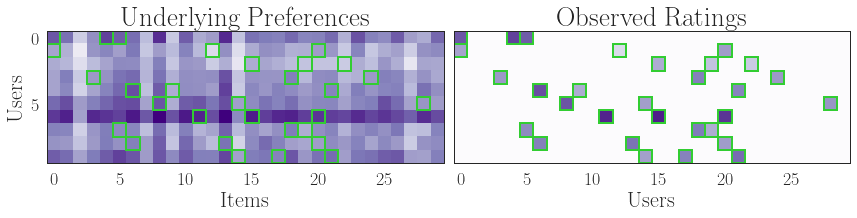

In [6]:
with context:
    fig, axs = plt.subplots(1,2,  figsize=(12, 3), sharey = True)
    axs[0].imshow(env.dense_ratings,vmin=1, vmax=5, cmap='Purples')
    highlight_entries(env.seen_mask, axs[0], color = 'limegreen', lw = 2)
    axs[1].imshow(np.multiply(env.seen_mask.todense(),env.dense_ratings), vmin=1, vmax=5, cmap = 'Purples')
    highlight_entries(env.seen_mask, axs[1], color = 'limegreen', lw = 2)
    axs[0].set_xlabel('Items')
    axs[1].set_xlabel('Items')
    axs[0].set_ylabel('Users')
    axs[1].set_xlabel('Users')
    axs[0].set_title('Underlying Preferences')
    axs[1].set_title('Observed Ratings')
    plt.tight_layout()
    plt.show()

The `LibFM` preference model is trained on the observed ratings when the evinroment is initialized. The trained model can be accessed via the `trained_model_dict` property.

In [7]:
env.trained_model_dict.keys()

dict_keys(['user_factors', 'user_bias', 'item_factors', 'item_bias', 'global_bias', 'kind'])

Given a trained preference model one can compute the predictions for the full dataset:

In [8]:
env.compute_dense_predictions()

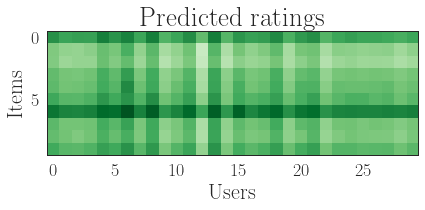

In [10]:
# Heatmap of predicted ratings
with context:
    fig, ax = plt.subplots(1,1, figsize=(6,3))
    ax.imshow(env.dense_predictions, vmin = 1, vmax = 5, cmap = 'Greens')
    ax.set_xlabel('Users')
    ax.set_ylabel('Items')
    ax.set_title('Predicted ratings')
    plt.tight_layout()
    plt.show()

## Running reachability audits

### Action Space

First, we need to define a user action space where for each user we select several items for which ratings can be strategically modified. These are known as `action items`; these items can either be history edits or future edits.

For the purposes of this demo, for each user we will assign `action_count = 3` action items by sampling that many items from the set of items that have not been previously observed. Thus, our action space is comprised of *Future Edits*.

In [11]:
action_item_mask = make_random_mask(env.seen_mask, count = 3)

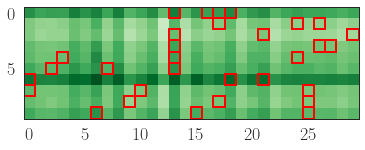

In [12]:
with context:
    fig, ax = plt.subplots(1,1,  figsize=(6, 3))
    ax.imshow(env.dense_predictions, vmin = 1, vmax = 5, cmap = 'Greens')
    highlight_entries(action_item_mask, ax,  color = 'red', lw = 2)
    plt.show()

### Target items
The remaining items; i.e. the ones that are not previosly observed and are not action items are known as *target* items. An item $i$ is a target item if one could set up an optimization problem to choose the optimal strategic action over the action items in order to maximize the probability of recommending item $i$.

In [13]:
target_item_mask = make_random_mask(env.seen_mask + action_item_mask, density = 1)

### Item selection rule
The probability of recommending an item $i$ to a user $u$ depends both on the score $s_{u,i}$, as well as the stochasticity of the item selection rule parametrized by $\beta$:
$$\rho_{u,i} \sim e^{\beta s_{u,i}}$$
Small $\beta$ values correspond to more stochastic selection rules whereas larger values correpond to more deterministic selection.

### Baseline reachability
We compute baseline reachability of the target items by assuming that each user acts non strategically and chooses the the predicted ratings as their action. Upon this we update the preference model and recompute the predicted score $s_{u,i}$

### Max reachability
To compute max reachability of an item we solve an optimization problem to find the optimal action $a^*_{u,i}$. This is the action such that if we add the corresponding ratings to the dataset the updated scores would yield the largest achievable probability of recommending item $i$ to user $u$: $\rho\star_{u,i}$. 

*Note: The preferences models are updating myopically; meaning that for each user's action vector we compute baseline and max reachability assuming that the only extra data provided to the model is the data pertaining to the individual user. Thus our results measure primarily first order strategic effects and do not consider collaborative effects.*  `TODO` <- say this better

In [14]:
%%capture
# reachability_audit for high beta value
beta_high = 5
max_rhos_high, baseline_rhos_high, _, _, _ = run_reachability_experiment(env, beta_high, target_item_mask, 
                                                                        action_item_mask, action_range = (1,5))
rho_gain_high = max_rhos_high - baseline_rhos_high
lift_high = entrywise_division(max_rhos_high, baseline_rhos_high) + env.seen_mask + action_item_mask

# reachability_audit for high beta value
beta_low = 2
max_rhos_low, baseline_rhos_low, _, _, _ = run_reachability_experiment(env, beta_low, target_item_mask, 
                                                                       action_item_mask, action_range = (1,5))
rho_gain_low = max_rhos_low - baseline_rhos_low
lift_low = entrywise_division(max_rhos_low, baseline_rhos_low) + env.seen_mask + action_item_mask

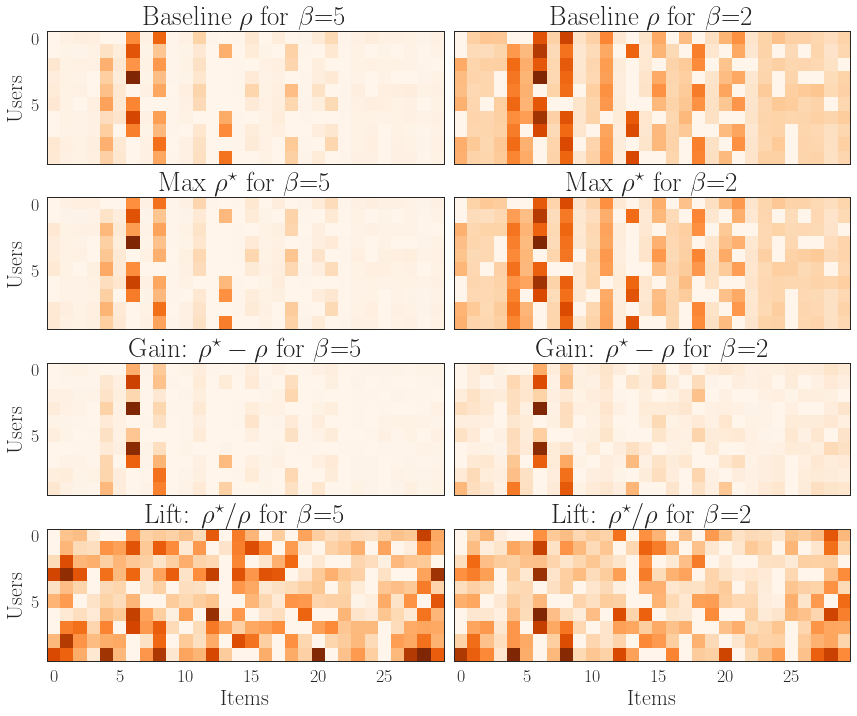

In [15]:
beta_dict = {0:beta_high, 1:beta_low}
res_dict = {0:'Baseline $\\rho$', 
            1:'Max $\\rho^\\star$', 
            2:'Gain: $\\rho^\\star - \\rho$',
            3:'Lift: $\\rho^\\star/ \\rho$'}
with context:
    fig, axs = plt.subplots(4, 2, figsize=(12,10), sharex = True, sharey=True)
    
    axs[0,0].imshow(baseline_rhos_high.todense(), cmap = 'Oranges')
    axs[1,0].imshow(max_rhos_high.todense(), cmap = 'Oranges')
    axs[2,0].imshow(rho_gain_high.todense(), cmap = 'Oranges')
    axs[3,0].imshow(lift_high.todense(), cmap = 'Oranges')
    
    axs[0,1].imshow(baseline_rhos_low.todense(), cmap = 'Oranges')
    axs[1,1].imshow(max_rhos_low.todense(), cmap = 'Oranges')
    axs[2,1].imshow(rho_gain_low.todense(), cmap = 'Oranges')
    axs[3,1].imshow(lift_low.todense(), cmap = 'Oranges')
    for i in range(4):
        for j in range(2):
            axs[3,j].set_xlabel('Items')
            axs[i,0].set_ylabel('Users')
            axs[i,j].set_title('{} for $\\beta$={}'.format(res_dict.get(i), beta_dict.get(j)))
    plt.tight_layout()
    plt.show()

Higher $\beta$ values correspond to more deterministic selection policies. The first row of images showcases how for $\beta = 2$ the recommendation is more stochastic than the case $\beta = 5$.

The second row contains a heatmap of max reachability values; the third row contains the reachability gain: $\rho^\star - \rho$. As it can be seen from the visual similarity of the first two row, the reachability increases most for items that already have high reachability values. One perhaps surprising observation is that the reachability gain does not depend too much on the  stochasticity of the policy.

Another metric we often consider is lift, which is defined as the ratio between the max reachability and the baseline reachability: $\lambda^\star = \frac{\rho\star}{\rho}$. The heatmap of lifts (bottom row) qualitatively looks very different from the other rows. This is because we might achieve very high lift by the virtua of having very small baselines for some items.

## YouTube Dataset

We further demonstrate a brief reachability audit for the LibFM recommender for the [Individual Logs dataset](https://github.com/sTechLab/YouTubeDurationData).

In [49]:
%%capture
# instanciate the YouTube environment
env = YouTubeEnvironment()
# initialize the environment
env.initialize()
# train LibFM recommender (optimal hyperparameters selected from models/best_params.json)
env.attach_recommender('libfm')

### Environment description

In [59]:
n_users = env.num_user
n_items = env.num_item
n_ratings = env.seen_mask.count_nonzero()
print("The YouTube dataset contains {} users and {} items.".format(n_users, n_items))
print("It contains {} ratings, which corresponds to {:.2f}% rating density.\n".format(n_ratings, 
                                                                                    n_ratings*100/(n_users*n_items)))

print("==============================\n======= USER ATTRIBUTES ======\n==============================")
display(env.user_attributes.tail(5))
print("\n==============================\n======= ITEM ATTRIBUTES ======\n==============================")
display(env.item_attributes.tail(5))

The YouTube dataset contains 154 users and 1741 items.
It contains 1807 ratings, which corresponds to 0.67% rating density.

======= USER ATTRIBUTES ======


,gender,zipcode
user_id,,
fbb89642-8331-7676-c14a-e4115755e9cc,Male,7945
fc1852c3-b72d-fa20-d932-6faf16de5b42,Female,90240
fdc63099-1fbb-f068-f840-1347441f6e1f,Male,60805
fe0468f0-99c3-7525-d0e4-830d7d2b7ed5,Female,78704
ff757a03-575d-0742-265e-9da441d6780a,Male,90046



======= ITEM ATTRIBUTES ======


,view_count,favorite_count,dislike_count,like_count,duration,publish_time,category,num_share,num_subscriber,average_view_duration,comment_count
item_id,,,,,,,,,,,
zrksjw66vkI,178681,0,84,7673,190.0,2014-06-19T03:26:54.000Z,Comedy,2,28,144.616187,177
zvkxYGDneCQ,381185,0,731,7302,117.0,2014-06-13T18:33:26.000Z,Film & Animation,171,71,92.936699,441
zxvXZrw_d-c,354581,0,169,435,294.0,2013-10-18T14:45:57.000Z,Education,6,157,57.487880,51
zzO4zqWQLvY,19346875,0,15253,216168,248.0,2013-10-30T12:00:01.000Z,Music,23353,7607,192.198287,3584
zzyizp74VTw,477671,0,335,8278,386.0,2014-01-22T14:16:28.000Z,Sports,749,208,153.117449,148


### Reachability experiment

In [77]:
%%capture 
#^^ remove this line to see experimental output
# it might take 5-7 minutes to complete

env.compute_dense_predictions()

run_users = set([0, 5, 34, 49, 56, 68, 79, 90, 126, 150])

# ----- Run reachability experiments ------
# Experimental results are saved in MODELPATH defined in utils/config.py

# Selects a random subset of previously rated items as action items for each user
run_dataset_history_experiment(env, target_densities = [1], action_counts= [5, 10, 20], goal_counts = [50],
                               betas = [1, 2, 4], title_str='history', run_users = run_users, common_goals = True)

# Action items are a random subset of NOT previously rated items
run_dataset_future_experiment(env, target_densities = [1], action_counts= [5, 10, 20], goal_counts = [50],
                               betas = [1, 2, 4], title_str='future', run_users = run_users, common_goals = True)

The results of running the reachability audits above are saved in the `EXPPATH` folder. See `utils/config.py` to setup paths.

The  experimental folder structure is showen below:
```
$EXPPATH/youtube_libfm/
├── future_2021-06-29-16:38
│   ├── action_10_goal_50_target_1_beta_1
│   │   ├── experiment.pkl
│   │   ├── user_0.pkl
│   │   ├── user_126.pkl
│   │   ├── user_150.pkl
│   │   ├── user_34.pkl
│   │   ├── user_49.pkl
│   │   ├── user_5.pkl
│   │   ├── user_56.pkl
│   │   ├── user_68.pkl
│   │   ├── user_79.pkl
│   │   └── user_90.pkl
│   ├── action_10_goal_50_target_1_beta_2
│   │   ├── experiment.pkl
│   │   ├── user_0.pkl
│   │   ├── ...
│   ├── action_10_goal_50_target_1_beta_4
│   │   ├── ...
│   ├── action_20_goal_50_target_1_beta_1
│   │   ├── ...
│   │   
│   └── params.pkl
└── history_2021-06-29-16:35
    ├── ...
```

### Loading reachability results

In [109]:
%%capture
_, history_exp_list = load_dataset_experiment(dataset_name='youtube', recommender_model='libfm', title_str='history')
_, future_exp_list = load_dataset_experiment(dataset_name='youtube', recommender_model='libfm', title_str='future')

In [158]:
history_df = make_combined_experiment_df(history_exp_list)
history_df['action_type'] = 'Random History'

future_df = make_combined_experiment_df(future_exp_list)
future_df['action_type'] = 'Random Future'

# combine all the dataframes
exp_df = pd.concat([history_df, future_df])

In [159]:
display(exp_df)

,index,User,Item,beta,action_count,baseline_rho_mat,max_rho_mat,baseline_rank_mat,max_rank_mat,lift,gain,rank_gain,action_type
0,0,0,82,2,20,3.000858e-07,0.000007,115,742,24.599998,0.000007,-627,Random History
1,1,0,190,2,20,4.169202e-07,0.000012,774,483,29.225243,0.000012,291,Random History
2,2,0,319,2,20,3.031130e-06,0.009871,379,20,3256.629949,0.009868,359,Random History
3,3,0,339,2,20,1.399615e-04,0.023192,1654,10,165.700471,0.023052,1644,Random History
4,4,0,387,2,20,4.596236e-06,0.000109,492,199,23.784307,0.000105,293,Random History
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3739,492,150,1630,1,5,3.971379e-04,0.002775,1595,35,6.988243,0.002378,1560,Random Future
3740,493,150,1654,1,5,5.328223e-04,0.007316,1566,23,13.729943,0.006783,1543,Random Future
3741,494,150,1681,1,5,6.290469e-04,0.001278,541,174,2.031685,0.000649,367,Random Future
3742,495,150,1694,1,5,2.898920e-04,0.000737,1582,364,2.543757,0.000448,1218,Random Future


### Plot reachability audit results

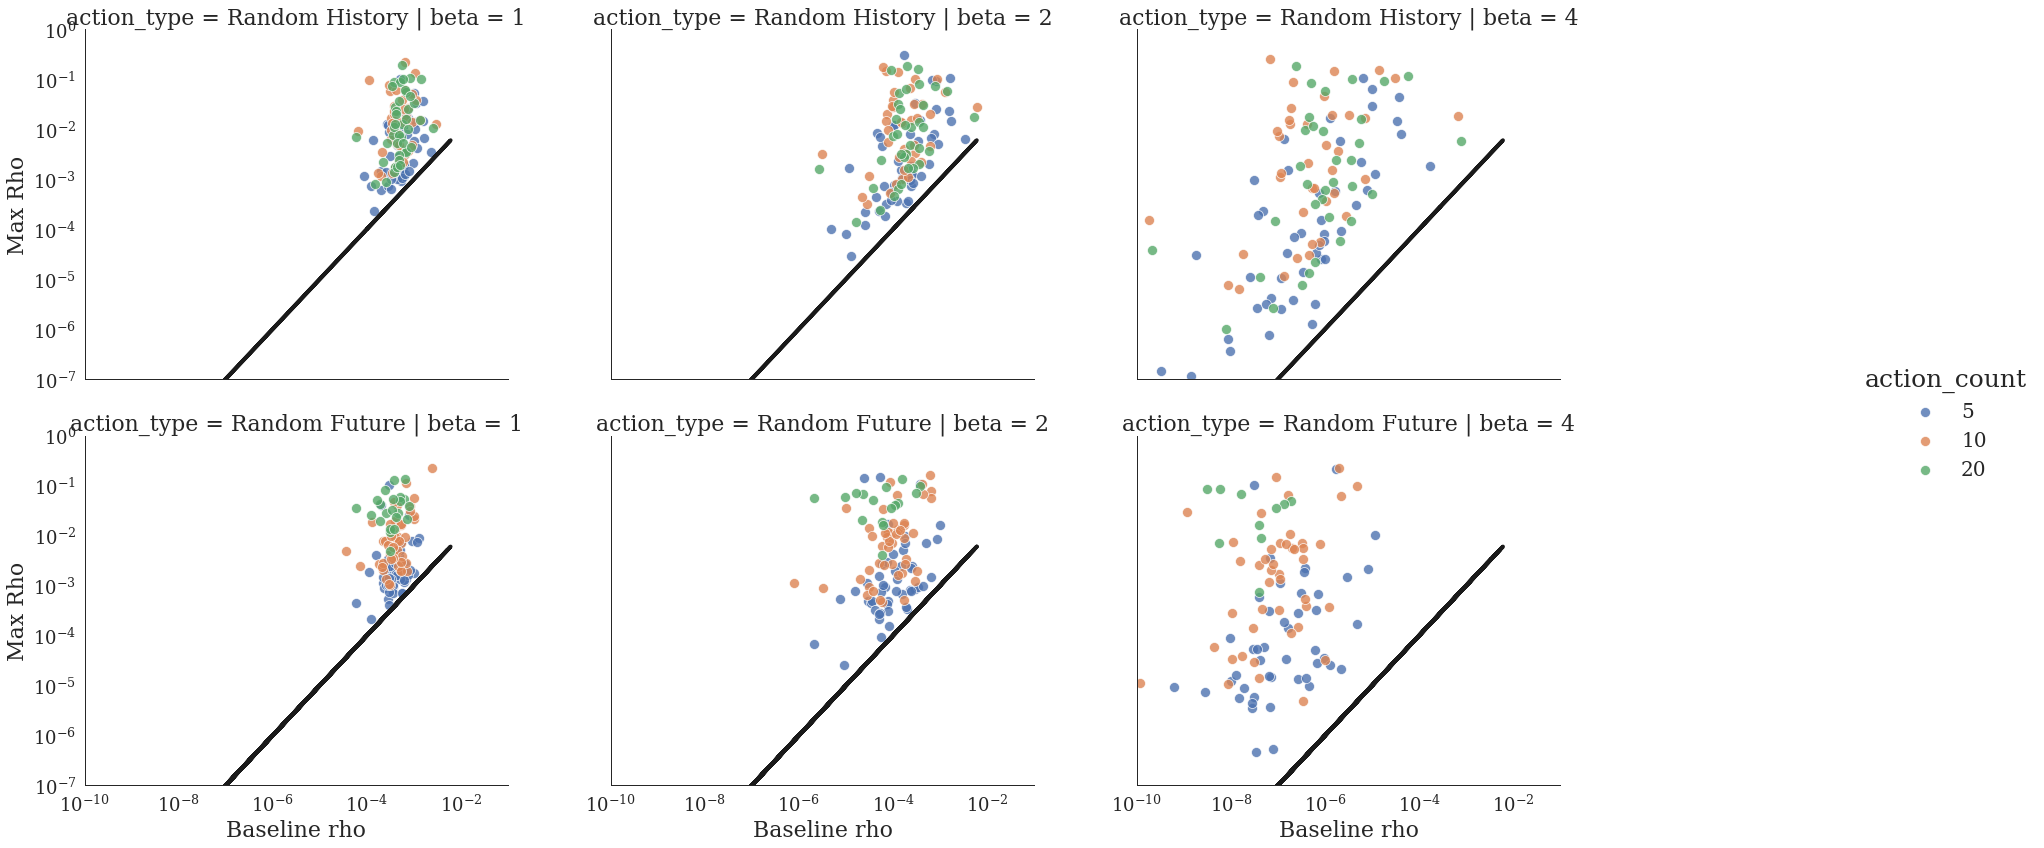

In [199]:
warnings.filterwarnings('ignore')

rc('text', usetex = False)
with context:
    g = sns.FacetGrid(user_exp_df, row = 'action_type', col = 'beta', hue = 'action_count')
    g.map_dataframe(sns.scatterplot, x='baseline_rho_mat', y = 'max_rho_mat', 
                    alpha = 0.8, s = 100).set(xscale="log",yscale="log", 
                                             ylim = [pow(10, -7), pow(10, 0)],
                                             xlim = [pow(10, -10), pow(10, -1)])
    for ax in g.axes.flat:
        ax.plot(user_exp_df['baseline_rho_mat'], user_exp_df['baseline_rho_mat'], 
                lw = 4, c ='k', label = 'No Improvement')
    
    g.set_axis_labels("Baseline rho", "Max Rho")
    g.add_legend()
    g.fig.set_figheight(12)
    g.fig.set_figwidth(30)
    plt.show()

Each point in the scatterplots above represents one item. The items that are higher above the "No Improvement" diagonal are more reachable. 

We can see that for small $\beta$ values the points are less spread out on the. meaning that most have probability of recommendation closed to random chance. 

Higher action counts uniformly improve reachability, while the type of action space (Random History or Random Future) does not seem to qualitatively affect item reachability.